# Игра "Космические братья". Анализ рекламных источников

Ссылка на презентацию: https://docs.google.com/presentation/d/1DLPsrkiOtK5LgfbUmmniBA3z6dO8SJ9sxX0EHmkBYfE/edit?usp=sharing

## Цели и задачи проекта

**Описание игры**: мобильная игра по строительству пользователями космических программ для колонизации галактики. Монетизация игры - просмотр рекламных роликов перед возможностью постройки игровых объектов.

**Цель проекта** - исследовать влияние источника перехода в игру на поведение пользователя (количество просмотренных рекламных роликов).

**Задачи проекта:**
- провести исследовательский анализ данных;
- исследовать влияние источника перехода в игру на поведение пользователя (количество просмотренных рекламных роликов);
- сформулировать статистические гипотезы и проверить статистическими тестами:
    1. *Гипотеза 1: время завершения уровня различается в зависимости способа прохождения:*
        - *через реализацию проекта,*
        - *через победу над первым игроком.*
    2. *Гипотеза 2: количество построенных объектов (или, что то же самое, просмотренных рекламных роликов) различается в зависимости от выбранной игроком стратегии: воители, строители.*

**Бизнес-задача**: увеличить доход от игры, увеличив среднее количество просмотренных рекламных роликов.

## Описание исходных данных

**Описание анализируемых данных**:
- данные пользователей;
- данные только по `уровню 1`;
- результат завершения уровня 1 (один из):
    - `победа над (первым) врагом`;
    - реализация проекта - `разработка орбитальной сборки спутников`.

## Получение и обзор данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats as st
import warnings
import sys

### Чтение файлов

In [2]:
# файлы ad_costs.csv, game_actions.csv, user_sourse.csv размещены по ссылкам соответственно:
yandex_disc_links = ['under NDA', 
                      'under NDA', 
                      'under NDA']

In [3]:
# также файлы размещены в google-облаке (доступ по ссылке открыт):
google_disc_links = ['under NDA',
                     'under NDA',
                     'under NDA']

In [4]:
# чтение данных датасетов в DataFrame-таблицы
ad_costs_df, game_actions_df, user_source_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
df_list = [ad_costs_df, game_actions_df, user_source_df]

for i in range(len(df_list)):
    try:
        df_list[i] = pd.read_csv(yandex_disc_links[i])
    except:
        url = google_disc_links[i]
        url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
        df_list[i] = pd.read_csv(url)
    display(df_list[i].head())
        
ad_costs_df, game_actions_df, user_source_df = df_list

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


### Обзор данных, формирование задач для предобработки данных

In [5]:
def bold_text(*agrs):
    w = ' '.join(*agrs)
    return '\033[1m' + w + '\033[0m'

In [6]:
def get_primal_info(df_list, df_names):
    for i, df in enumerate(df_list):
        print(bold_text(['Общий обзор таблицы', df_names[i]]), end='\n\n')
        print('\t', bold_text(['Общий обзор методом info']))
        print(df_list[i].info(), end='\n\n')
        print('\t', bold_text(['Общий обзор методом describe']))
        print(df_list[i].describe(datetime_is_numeric=True), end='\n\n')
        print('\t', bold_text(['Общий обзор методом value_counts']))
        print(df_list[i].value_counts(), end='\n\n')
        print('\t', bold_text(['Процент пропущенных значений']))
        print(df_list[i].isna().mean()*100, end='\n\n')
        print('\t', bold_text(['Количество явных дубликатов']))
        print(df_list[i].duplicated().sum(), end='\n\n')
        

In [7]:
get_primal_info(df_list, df_names=['ad costs', 'game actions', 'user source'])

Общий обзор таблицы ad costs

	 Общий обзор методом info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None

	 Общий обзор методом describe
             cost
count   28.000000
mean   271.556321
std    286.867650
min     23.314669
25%     66.747365
50%    160.056443
75%    349.034473
max    969.139394

	 Общий обзор методом value_counts
source                   day         cost      
facebook_ads             2020-05-03  935.882786    1
                         2020-05-04  548.354480    1
youtube_channel_reklama  2020-05-08  40.217907     1
                         2020-05-07  55.740645     1
                         2020-05-06  88.506074     1
                         2020-05-05  147.041741    

**Задачи для этапа предобработки таблицы ad_costs_df**:
- заменить тип данных в колонке `day` на `datetime`.

Пропущенные значения отсутствуют, наименования колонок выполнены в формате snake_case, явных дубликатов нет.

**Задачи для этапа предобработки таблицы game_actions_df**:
- заменить тип данных в колонке `event_datetime` на `datetime`,
- рассмотреть пропущенные значения в колонках `building_type`, `project_type`,
- рассмотреть 1 явный дубликат.

Наименования колонок выполнены в формате snake_case.

**Задачи для этапа предобработки таблицы user_source_df**: отсутствуют.

Пропущенные значения отсутствуют, тип данных соответствует доменным областям, наименования колонок выполнены в формате snake_case, явных дубликатов нет.

In [8]:
# количество уникальных пользователей
game_actions_df.user_id.nunique()

13576

In [9]:
# проверим, существуют ли 'органические' пользователи или все рассматриваемые пользователи пришли из рекламных каналов
if len(game_actions_df.user_id.unique()) == len(user_source_df.user_id.unique()):
    print('Все пользователи пришли из рекламных каналов. "Органические" пользователи отсутствуют.')
else:
    print('Данные представлены, в том числе, для "органических" пользователей.')

Все пользователи пришли из рекламных каналов. "Органические" пользователи отсутствуют.


In [10]:
# период пользовательской активности
print(f'Первая запись логов: {game_actions_df.event_datetime.min()}')
print(f'Последняя запись логов: {game_actions_df.event_datetime.max()}')

Первая запись логов: 2020-05-04 00:00:01
Последняя запись логов: 2020-06-05 12:32:49


## Предобработка данных

### Задачи для предобработки данных

1. Для таблицы `ad_costs_df`:
    - заменить тип данных в колонке `day` на `datetime`


2. Для таблицы `game_actions_df`:
    - рассмотреть 1 явный дубликат,
    - заменить тип данных в колонке `event_datetime` на `datetime`,
    - рассмотреть пропущенные значения в колонках `building_type`, `project_type`. Рассмотреть возможность замены пропущенных данных на значения или значения-заглушки.

### Предобработка данных

**Обработка таблицы `ad_costs_df`**

In [11]:
# замена типа данных в колонке day на datetime
ad_costs_df['day'] = pd.to_datetime(ad_costs_df['day'])

In [12]:
# проверка
ad_costs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


**Обработка таблицы `game_actions_df`**

In [13]:
# удаление явного дубликата
print(game_actions_df.duplicated().sum())
game_actions_df.drop_duplicates(inplace=True)
print(game_actions_df.duplicated().sum())

1
0


In [14]:
# замена типа данных в колонке event_datetime на datetime
game_actions_df['event_datetime_full'] = game_actions_df['event_datetime']
game_actions_df['event_datetime'] = pd.to_datetime(game_actions_df['event_datetime']).dt.date
game_actions_df['event_datetime'] = pd.to_datetime(game_actions_df['event_datetime'])

In [15]:
# пропущенные значения в колонке building_type
if len(game_actions_df.query('building_type != building_type and event == "building"')) == 0:
    print('''Пропущенные значения в колонке building_type относятся к событиям, которые не связаны со строительством объектов.
    Меняем пропущенные значения на строковое значение-заглушку "None"''')
    game_actions_df['building_type'] = game_actions_df['building_type'].fillna('None')

Пропущенные значения в колонке building_type относятся к событиям, которые не связаны со строительством объектов.
    Меняем пропущенные значения на строковое значение-заглушку "None"


In [16]:
None == 'None'

False

In [17]:
# пропущенные значения в колонке project_type, очевидно, относятся к тем пользователям, которые не реализовали 
# программу строительства проекта 'орбитальной сборки спутников' в этом случае можем заменить пропущенные значения 
# на значение-заглушку 'None'
game_actions_df['project_type'] = game_actions_df['project_type'].fillna('None')

In [18]:
# проверка
game_actions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   event_datetime       135639 non-null  datetime64[ns]
 1   event                135639 non-null  object        
 2   building_type        135639 non-null  object        
 3   user_id              135639 non-null  object        
 4   project_type         135639 non-null  object        
 5   event_datetime_full  135639 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 7.2+ MB


In [19]:
# создадим список user_id тех пользователей, кто в рассматриваемый период завершил уровень 1
finished_users_ids_set = set(game_actions_df.query('event == "finished_stage_1"').user_id.to_list())

In [20]:
# создадим список user_id тех пользователей, кто в рассматриваемый период не завершил уровень 1
unfinished_users_ids_set = set(game_actions_df.user_id.to_list()) - finished_users_ids_set

In [21]:
# найдём пользователей, которые завершили проект 'орбитальной сборки спутников', но за наблюдаемый период не завершили уровень 1
print('Количество пользователей, завершивших проект, но не завершивших 1 уровень -',
      len(game_actions_df[(game_actions_df['project_type'] != "None") & (game_actions_df['user_id'].isin(unfinished_users_ids_set))]),
      'чел.')

Количество пользователей, завершивших проект, но не завершивших 1 уровень - 0 чел.


Таким образом, можно сделать вывод, что множества пользователей не пересекаются:
- завершили уровень, победив врага (предполагает автоматическое завершение уровня) - далее - 'воители';
- завершили уровень, реализовав программу строительства проекта 'орбитальной сборки спутников' (не предполагает автоматическое завершение уровня) - далее - 'строители';
- не завершили уровень (не победили врага, не реализовали проект 'орбитальной сборки спутников').

In [22]:
# разделим finished_users_ids_set на множество user_id 'воителей' (warrior_users) и 'строителей' (builder_users)
builder_users_set = set(game_actions_df[(game_actions_df['project_type'] != 'None') \
                                         & (game_actions_df['user_id'].isin(finished_users_ids_set))] \
                         .user_id.to_list())

In [23]:
warrior_users_set = finished_users_ids_set - builder_users_set

In [24]:
# проверка и выводы
print(f'''Общее количество пользователей - {len(game_actions_df.user_id.unique())}, \n
из них завершили уровень 1 - {len(finished_users_ids_set)} или {round(len(finished_users_ids_set) * 100 / len(game_actions_df.user_id.unique()), 1)}%,
\tиз них воителей - {len(warrior_users_set)} ({round(len(warrior_users_set) * 100 / len(game_actions_df.user_id.unique()), 1)}%),
\tиз них строителей - {len(builder_users_set)} ({round(len(builder_users_set) * 100 / len(game_actions_df.user_id.unique()), 1)}%), \n
остались на уровне 1 - {len(unfinished_users_ids_set)} или {round(len(unfinished_users_ids_set) * 100 / len(game_actions_df.user_id.unique()), 1)}%''')

Общее количество пользователей - 13576, 

из них завершили уровень 1 - 5817 или 42.8%,
	из них воителей - 3951 (29.1%),
	из них строителей - 1866 (13.7%), 

остались на уровне 1 - 7759 или 57.2%


In [25]:
users_strategies_df = pd.DataFrame(game_actions_df.user_id.unique(), columns=['ids'])

In [26]:
def mark_status(id):
    '''функция возвращает статус пользователя по его id'''
    if id in warrior_users_set:
        return 'warriors'
    if id in builder_users_set:
        return 'builders'
    else:
        return 'stayed'

In [27]:
users_strategies_df['status'] = users_strategies_df['ids'].apply(mark_status)

In [28]:
df_to_plot = users_strategies_df.groupby('status', as_index=False).agg(ids_count = ('ids', 'count'))

In [29]:
df_to_plot

,status,ids_count
0,builders,1866
1,stayed,7759
2,warriors,3951


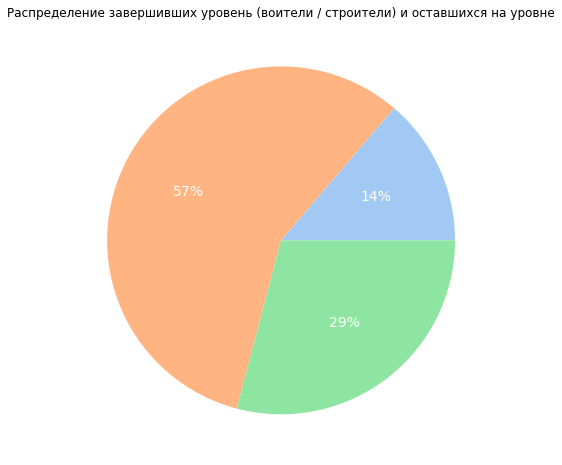

In [30]:
plt.figure(figsize=(15, 8))
colors = sns.color_palette('pastel')[0:3]
plt.pie(df_to_plot.ids_count, labels = df_to_plot.status, colors = colors, autopct='%.0f%%', textprops={'fontsize': 14, 'color': 'white'})
plt.title('Распределение завершивших уровень (воители / строители) и оставшихся на уровне')

plt.show()

### Выводы

В процессе предобработки данных:
- заменены тип данных в колонках со значениями времени `day` на `datetime` в таблицах `ad_costs_df`, `game_actions_df`;
- в таблице `game_actions_df`:
    - удален 1 явный дубликат,
    - пропущенные значения в колонках `building_type`, `project_type` заменены на строковые значения-заглушки;
- данные представлены для 3 непересекающихся множества пользователей: `воители`, `строители`, оставшихся на уровне 1.

## Исследовательский анализ данных

### Задачи для исследовательского анализа данных

1. Объединить таблицы для формирования данных по источникам привлечения пользователей (органические пользователи, рекламные).
2. Рассчитать, какой процент пользователей завершает уровень 1 в разрезе источников привлечения. Построить графики.
3. Рассчитать время завершения игры для каждого завершившего. Построить график распределения по количеству дней в разрезе источников привлечения. Построить график распределения по количеству дней в разрезе используемой стратегии (победа над врагом / реализация проекта).
4. Рассчитать кумулятивное количество построек по количеству дней в разрезе источников привлечения.
5. Вычислить стоимость привлечения каждого пользователя. Выявить самые дорогие и дешевые источники привлечения пользователей.
6. Рассчитать LTV (доход от суммарного показа рекламных роликов - стоимость привлечения) в разрезе источников привлечения.

### Исследовательский анализ данных

Монетизация игры - просмотр рекламных роликов перед возможностью постройки игровых объектов (принимается условный доход от показа в 0.07 у.е.).

#### Объединить таблицы для формирования данных по источникам привлечения пользователей (органические пользователи, рекламные).

Объединим таблицу `game_actions_df` с данными таблицы `user_source_df` по `user_id`, тем самым добавим каждому пользователю сведения о том, из какого канала он вошел в игру.

In [31]:
game_actions_df_and_sources = game_actions_df.merge(user_source_df, how='left', left_on='user_id', right_on='user_id')

Рассмотрим, какое количество пользователей ежедневно присоединялось к игре в разрезе источников. Для этого найдем дату первого входа в игру для каждого пользователя.

In [32]:
first_session = game_actions_df_and_sources.sort_values(by='event_datetime', ascending=True) \
                                            .groupby(['user_id', 'source'], as_index=False) \
                                            .agg(first_session_date=('event_datetime', 'first'), \
                                                 first_session_date_full=('event_datetime_full', 'first'))

In [33]:
# присоединим данные таблицы first_session к game_actions_df_and_sources
game_actions_df_and_sources_first_visit = game_actions_df_and_sources.merge(first_session[['user_id', 'first_session_date']], how='left', on='user_id')

In [34]:
first_session_users_number = first_session.groupby(['first_session_date', 'source'], as_index=False) \
                                            .agg(user_count=('user_id', 'count')) \
                                            .sort_values(by=['source', 'first_session_date'], ascending=True)

In [35]:
# проверка
first_session_users_number.head()

,first_session_date,source,user_count
0,2020-05-04,facebook_ads,1184
4,2020-05-05,facebook_ads,694
8,2020-05-06,facebook_ads,345
12,2020-05-07,facebook_ads,224
16,2020-05-08,facebook_ads,139


Рассчитаем среднюю стоимость привлечения

In [36]:
# создадим копию таблицу со стоимостью привлечения пользователей и изменим дату на +1 день, 
# чтобы это соответствовало данным в таблице game_actions_df
ad_costs_df_offset = ad_costs_df.copy()
ad_costs_df_offset['day'] = pd.DatetimeIndex(ad_costs_df_offset['day']) + pd.DateOffset(1)

In [37]:
# объединим таблицы first_session_users_number и ad_costs_df_offset
first_session_users_number_costs = first_session_users_number.merge(ad_costs_df_offset, 
                                                                    how='inner', left_on=['first_session_date', 'source'],
                                                                   right_on=['day', 'source'])

In [38]:
first_session_users_number_costs.drop('day', axis=1, inplace=True)

In [39]:
first_session_users_number_costs['avg_user_acquisition_cost'] = first_session_users_number_costs.cost / first_session_users_number_costs.user_count

In [40]:
# проверка
first_session_users_number_costs.head()

,first_session_date,source,user_count,cost,avg_user_acquisition_cost
0,2020-05-04,facebook_ads,1184,935.882786,0.790442
1,2020-05-05,facebook_ads,694,548.354480,0.790136
2,2020-05-06,facebook_ads,345,260.185754,0.754162
3,2020-05-07,facebook_ads,224,177.982200,0.794563
4,2020-05-08,facebook_ads,139,111.766796,0.804078


In [41]:
# присоединим таблицу first_session_users_number_costs к таблице game_actions_df_and_sources_first_visit
united_user_data = game_actions_df_and_sources_first_visit \
                        .merge(first_session_users_number_costs[['first_session_date', 'source', 'avg_user_acquisition_cost']], \
                               how='left', left_on=['first_session_date', 'source'], right_on=['first_session_date', 'source'])

In [42]:
# проверка
united_user_data.head()

,event_datetime,event,building_type,user_id,project_type,event_datetime_full,source,first_session_date,avg_user_acquisition_cost
0,2020-05-04,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,None,2020-05-04 00:00:01,youtube_channel_reklama,2020-05-04,0.396357
1,2020-05-04,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,None,2020-05-04 00:00:03,facebook_ads,2020-05-04,0.790442
2,2020-05-04,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,None,2020-05-04 00:00:16,instagram_new_adverts,2020-05-04,0.649590
3,2020-05-04,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,None,2020-05-04 00:00:16,facebook_ads,2020-05-04,0.790442
4,2020-05-04,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,None,2020-05-04 00:00:35,yandex_direct,2020-05-04,0.466381


In [43]:
united_user_data.shape

(135639, 9)

#### Рассчитать, какой процент пользователей завершает уровень 1 в разрезе источников привлечения. Построить графики.

In [44]:
# добавим в таблицу united_user_data метку True / False о том, завершил ли пользователь уровень 1
united_user_data['level_passed_flag'] = united_user_data['event'].apply(lambda x: True if x == 'finished_stage_1' else False)

In [45]:
# проверка
if united_user_data['level_passed_flag'].sum() == len(finished_users_ids_set):
    print('Все пользователи, прошедшие уровень 1 получили метку True')
else:
    print('Внимание! Метки добавлены некорректно. Необходимо проверить.')
    sys.exit()

Все пользователи, прошедшие уровень 1 получили метку True


In [46]:
level_passed_users_share = united_user_data.groupby(['first_session_date', 'source'], as_index=False).agg(count=('user_id', 'nunique'), level_passed_user_count=('level_passed_flag', 'sum'))

In [47]:
level_passed_users_share['share'] = level_passed_users_share['level_passed_user_count'] * 100 / level_passed_users_share['count']

In [48]:
level_passed_users_share.head()

,first_session_date,source,count,level_passed_user_count,share
0,2020-05-04,facebook_ads,1184,531,44.847973
1,2020-05-04,instagram_new_adverts,1452,679,46.763085
2,2020-05-04,yandex_direct,2078,917,44.128970
3,2020-05-04,youtube_channel_reklama,1146,543,47.382199
4,2020-05-05,facebook_ads,694,312,44.956772


In [49]:
level_passed_users_share.groupby('source', as_index=False).agg(median_share=('share', 'median')).sort_values(by='median_share', ascending=False)

,source,median_share
1,instagram_new_adverts,38.888889
0,facebook_ads,38.095238
2,yandex_direct,37.974684
3,youtube_channel_reklama,36.818182


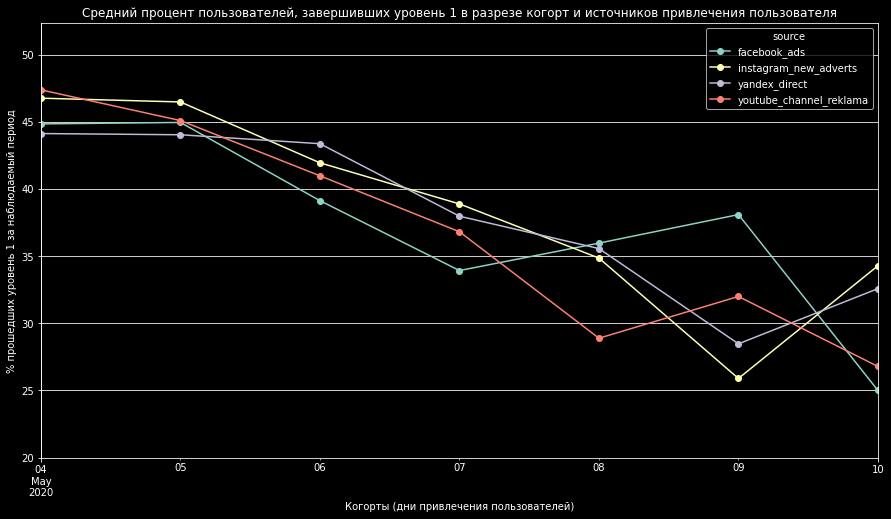

In [50]:
plt.style.use('dark_background')
level_passed_users_share.pivot_table(values='share', index='first_session_date', columns='source') \
.plot(grid=True, figsize=(15, 8), title='Средний процент пользователей, завершивших уровень 1 в разрезе когорт и источников привлечения пользователя', \
                              xlabel='Когорты (дни привлечения пользователей)', ylabel='% прошедших уровень 1 за наблюдаемый период', \
                              linestyle='-', marker='o')
plt.ylim((level_passed_users_share.share.min() - 5, level_passed_users_share.share.max() + 5))
plt.show()

Между когортами наблюдается снижение целеустремленности, на что существенно влияет количество игроков в когортах: в когорте от 4 мая закупка на порядок больше по всем источникам, чем в когорте от 10 мая.
45-50% игроков, привлеченных 04 мая, завершают уровень 1, в то время, как процент таких игроков от 10 мая не превышает 35%.


#### Рассчитать время завершения игры для каждого завершившего. Построить график распределения по количеству дней в разрезе источников привлечения. Построить график распределения по количеству дней в разрезе используемой стратегии (победа над врагом / реализация проекта).

In [51]:
# добавим в таблицу united_user_data столбец с датой завершения уровня
# таблица с датой завершения
level_passed_dates = united_user_data.query('event == "finished_stage_1"')[['user_id', 'event_datetime']]

In [52]:
united_user_data = united_user_data.merge(level_passed_dates, how='left', on='user_id')

In [53]:
united_user_data.rename(columns={'event_datetime_x': 'event_datetime', 'event_datetime_y': 'level_passed_date'}, inplace=True)

In [54]:
# проверка
united_user_data.head()

,event_datetime,event,building_type,user_id,project_type,event_datetime_full,source,first_session_date,avg_user_acquisition_cost,level_passed_flag,level_passed_date
0,2020-05-04,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,None,2020-05-04 00:00:01,youtube_channel_reklama,2020-05-04,0.396357,False,NaT
1,2020-05-04,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,None,2020-05-04 00:00:03,facebook_ads,2020-05-04,0.790442,False,2020-05-15
2,2020-05-04,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,None,2020-05-04 00:00:16,instagram_new_adverts,2020-05-04,0.649590,False,2020-05-16
3,2020-05-04,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,None,2020-05-04 00:00:16,facebook_ads,2020-05-04,0.790442,False,NaT
4,2020-05-04,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,None,2020-05-04 00:00:35,yandex_direct,2020-05-04,0.466381,False,2020-05-11


In [55]:
query = ((united_user_data['level_passed_date'] == united_user_data['level_passed_date']) & (united_user_data['event'] == 'finished_stage_1'))
level_pass_duration = united_user_data[query][['user_id', 'source', 'first_session_date', 'level_passed_date']].copy()

In [56]:
# проверка
level_pass_duration.shape[0] == len(finished_users_ids_set)

True

In [57]:
level_pass_duration['duration'] = level_pass_duration['level_passed_date'] - level_pass_duration['first_session_date']

In [58]:
level_pass_duration['duration'] = level_pass_duration['duration'].dt.days

In [59]:
# проверка
level_pass_duration.head()

,user_id,source,first_session_date,level_passed_date,duration
6659,ced7b368-818f-48f6-9461-2346de0892c5,instagram_new_adverts,2020-05-04,2020-05-04,0
13134,7ef7fc89-2779-46ea-b328-9e5035b83af5,facebook_ads,2020-05-04,2020-05-05,1
15274,70db22b3-c2f4-43bc-94ea-51c8d2904a29,youtube_channel_reklama,2020-05-04,2020-05-05,1
16284,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,youtube_channel_reklama,2020-05-04,2020-05-05,1
19650,58e077ba-feb1-4556-a5a0-d96bd04efa39,facebook_ads,2020-05-04,2020-05-06,2


In [60]:
median_level_pass_duration = level_pass_duration.groupby(['source', 'first_session_date'], as_index=False).agg(median_duration=('duration', 'median'))

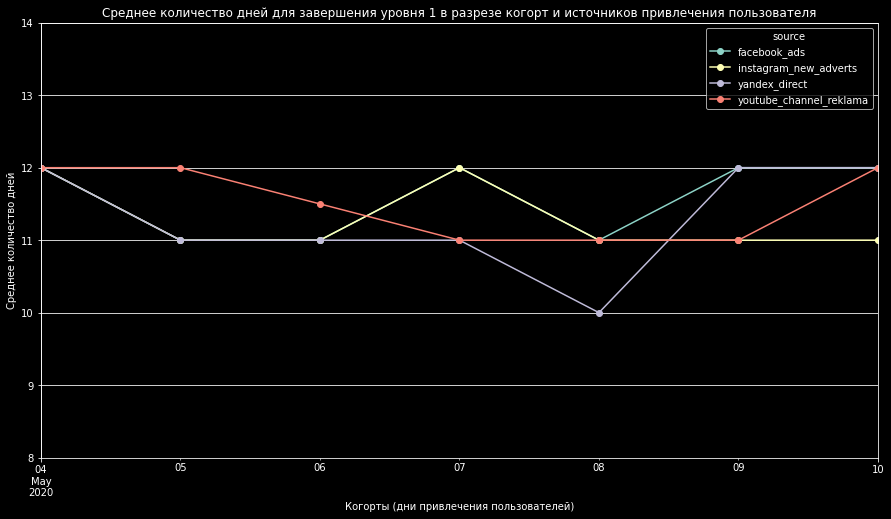

In [61]:
plt.style.use('dark_background')
median_level_pass_duration.pivot_table(values='median_duration', index='first_session_date', columns='source') \
.plot(grid=True, figsize=(15, 8), title='Среднее количество дней для завершения уровня 1 в разрезе когорт и источников привлечения пользователя', \
                              xlabel='Когорты (дни привлечения пользователей)', ylabel='Среднее количество дней', \
                              linestyle='-', marker='o')
plt.ylim((median_level_pass_duration.median_duration.min() - 2, median_level_pass_duration.median_duration.max() + 2))

plt.show()

Медианное количество дней для завершения уровня 1 (без учета стратегии прохождения уровня) варьируется от 10 до 12 дней, то есть достаточно устойчиво для всех рассматриваемых когорт.
Далее рассмотрим, насколько отличается среднее количество дней для прохождения уровня в зависимости от стратегии прохождения.

In [62]:
# добавим в имеющуюся таблицу level_pass_duration информацию о стратегии пользователя (ранее мы создали 2 множества с user_id воителей и строителей: warrior_users_set и builder_users_set).


In [63]:
level_pass_duration['user_strategy'] = level_pass_duration['user_id'].apply(lambda x: 'warrior' if x in warrior_users_set else 'builder')

In [64]:
# проверка
level_pass_duration.query('user_strategy == "warrior"').user_id.count() == len(warrior_users_set)

True

In [65]:
# проверка
level_pass_duration.query('user_strategy == "builder"').user_id.count() == len(builder_users_set)

True

In [66]:
median_level_pass_duration = level_pass_duration.groupby(['source', 'first_session_date', 'user_strategy'], as_index=False).agg(median_duration=('duration', 'median'))

In [67]:
median_level_pass_duration.head()

,source,first_session_date,user_strategy,median_duration
0,facebook_ads,2020-05-04,builder,13.0
1,facebook_ads,2020-05-04,warrior,11.0
2,facebook_ads,2020-05-05,builder,12.0
3,facebook_ads,2020-05-05,warrior,10.5
4,facebook_ads,2020-05-06,builder,14.0


In [68]:
# рассмотрим медианную продолжительность завершения уровня 1 для пользователей по всем когортам в разрезе источников
median_level_pass_duration.query('user_strategy == "builder"').groupby('source', as_index=False).agg({'median_duration': 'median'})

,source,median_duration
0,facebook_ads,13.0
1,instagram_new_adverts,14.0
2,yandex_direct,13.0
3,youtube_channel_reklama,13.0


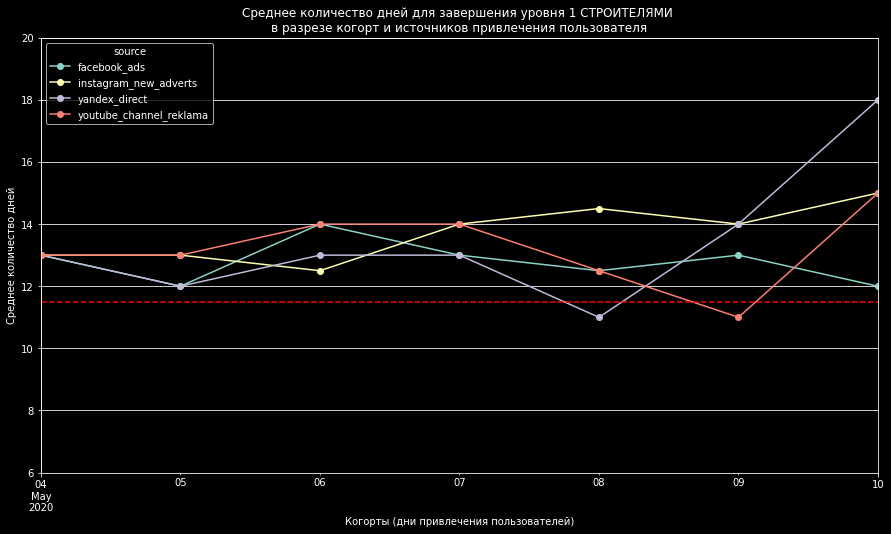

In [69]:
plt.style.use('dark_background')
median_level_pass_duration.query('user_strategy == "builder"').pivot_table(values='median_duration', index='first_session_date', columns='source') \
.plot(grid=True, figsize=(15, 8), title='Среднее количество дней для завершения уровня 1 СТРОИТЕЛЯМИ \nв разрезе когорт и источников привлечения пользователя', \
                              xlabel='Когорты (дни привлечения пользователей)', ylabel='Среднее количество дней', \
                              linestyle='-', marker='o')
plt.ylim((median_level_pass_duration.median_duration.min() - 2, median_level_pass_duration.median_duration.max() + 2))
plt.axhline(median_level_pass_duration.median_duration.median(), c='red', ls='--', label='')
plt.show()

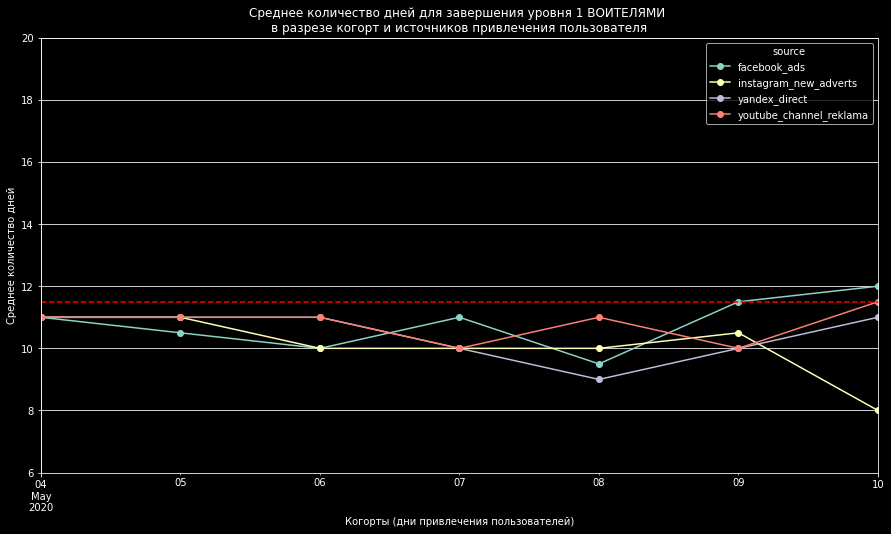

In [70]:
plt.style.use('dark_background')
median_level_pass_duration.query('user_strategy == "warrior"').pivot_table(values='median_duration', index='first_session_date', columns='source') \
.plot(grid=True, figsize=(15, 8), title='Среднее количество дней для завершения уровня 1 ВОИТЕЛЯМИ \nв разрезе когорт и источников привлечения пользователя', \
                              xlabel='Когорты (дни привлечения пользователей)', ylabel='Среднее количество дней', \
                              linestyle='-', marker='o')
plt.ylim(median_level_pass_duration.median_duration.min() - 2, median_level_pass_duration.median_duration.max() + 2)
plt.axhline(median_level_pass_duration.median_duration.median(), c='red', ls='--')

plt.show()

In [71]:
# рассмотрим медианную продолжительность завершения уровня 1 для пользователей-воителей по всем когортам в разрезе источников
median_level_pass_duration.query('user_strategy == "warrior"').groupby('source', as_index=False).agg({'median_duration': 'median'})

,source,median_duration
0,facebook_ads,11.0
1,instagram_new_adverts,10.0
2,yandex_direct,11.0
3,youtube_channel_reklama,11.0


In [72]:
print(f'Медианное значение среднего времени прохождения уровня по всем когортам и без учета стратегий', median_level_pass_duration.median_duration.median(), 'дней')
print(f'Медианное значение среднего времени прохождения уровня пользователями-строителями', median_level_pass_duration.query('user_strategy == "builder"').median_duration.median(), 'дней')
print(f'Медианное значение среднего времени прохождения уровня пользователями-воителями', median_level_pass_duration.query('user_strategy == "warrior"').median_duration.median(), 'дней')

Медианное значение среднего времени прохождения уровня по всем когортам и без учета стратегий 11.5 дней
Медианное значение среднего времени прохождения уровня пользователями-строителями 13.0 дней
Медианное значение среднего времени прохождения уровня пользователями-воителями 11.0 дней


Анализ графиков показывает, что пользователи-воители проходят уровень на 2 дня быстрее, чем пользователи-строители.

#### Рассчитать медианное количество объектов, построенных за день, в разрезе источников привлечения.

In [73]:
united_user_data.head()

,event_datetime,event,building_type,user_id,project_type,event_datetime_full,source,first_session_date,avg_user_acquisition_cost,level_passed_flag,level_passed_date
0,2020-05-04,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,None,2020-05-04 00:00:01,youtube_channel_reklama,2020-05-04,0.396357,False,NaT
1,2020-05-04,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,None,2020-05-04 00:00:03,facebook_ads,2020-05-04,0.790442,False,2020-05-15
2,2020-05-04,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,None,2020-05-04 00:00:16,instagram_new_adverts,2020-05-04,0.649590,False,2020-05-16
3,2020-05-04,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,None,2020-05-04 00:00:16,facebook_ads,2020-05-04,0.790442,False,NaT
4,2020-05-04,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,None,2020-05-04 00:00:35,yandex_direct,2020-05-04,0.466381,False,2020-05-11


In [74]:
# воспользуемся таблицей united_user_data, добавим новую колонку: является ли событие постройкой (читай: посмотрит ли пользователь рекламный ролик)
united_user_data['is_building_flag'] = united_user_data['event'].apply(lambda x: True if x == 'building' else False)

In [75]:
# Необходимо: сгруппировать таблицу по event_datetime и source, агрегировать по количеству построек
avg_buildings_per_user = united_user_data.groupby(['event_datetime', 'source'], as_index=False) \
                                          .agg(buildings_count=('is_building_flag', 'sum'), users_count=('user_id', 'nunique'))

In [76]:
avg_buildings_per_user['avg_buildings_per_day'] = avg_buildings_per_user['buildings_count'] / avg_buildings_per_user['users_count']

In [77]:
# проверка
avg_buildings_per_user.sort_values(by='avg_buildings_per_day', ascending=False)

,event_datetime,source,buildings_count,users_count,avg_buildings_per_day
25,2020-05-10,instagram_new_adverts,3844,2301,1.670578
27,2020-05-10,youtube_channel_reklama,2918,1787,1.632904
24,2020-05-10,facebook_ads,2996,1860,1.610753
26,2020-05-10,yandex_direct,5264,3271,1.609294
16,2020-05-08,facebook_ads,2509,1583,1.584965
...,...,...,...,...,...
119,2020-06-02,youtube_channel_reklama,1,3,0.333333
118,2020-06-02,yandex_direct,0,3,0.000000
125,2020-06-04,instagram_new_adverts,0,1,0.000000
127,2020-06-05,facebook_ads,0,1,0.000000


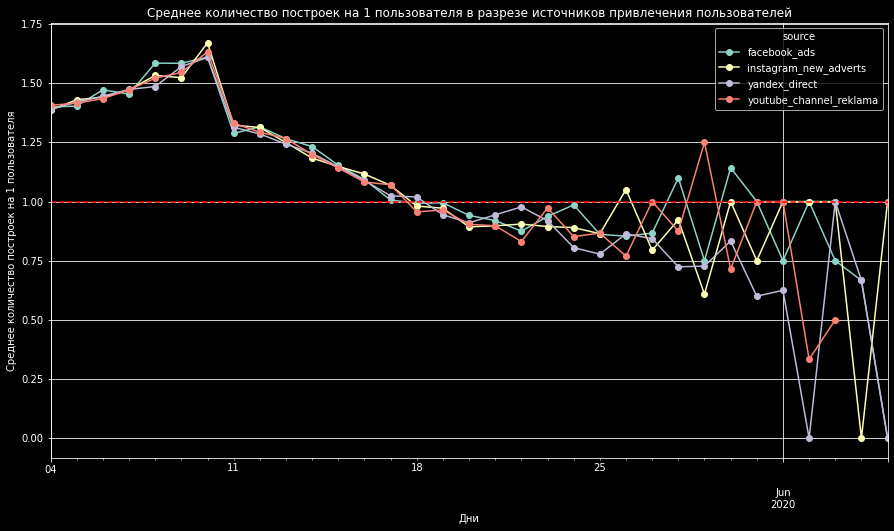

In [78]:
plt.style.use('dark_background')
avg_buildings_per_user.pivot_table(values='avg_buildings_per_day', index='event_datetime', columns='source') \
.plot(grid=True, figsize=(15, 8), title='Среднее количество построек на 1 пользователя в разрезе источников привлечения пользователей', \
                              xlabel='Дни', ylabel='Среднее количество построек на 1 пользователя', \
                              linestyle='-', marker='o')
plt.axhline(avg_buildings_per_user.avg_buildings_per_day.median(), c='red', ls='--')

plt.show()

Анализ графика показывает, что пользователи всех когорт, вне зависимости от канала привлечения, в среднем, с одинаковой интенсивностью возводят построки. В конце наблюдения разница становится существенной, но ранонаправленной между соседними днями. То есть может быть объяснена существенным снижением количества игроков (DAU) в связи с тем, что наиболее активная часть пользователей уже завершила уровень.

#### Вычислить стоимость привлечения каждого пользователя. Выявить самые дорогие и дешевые источники привлечения пользователей.

In [79]:
# воспользуемся ранее созданной таблицей first_session_users_number_costs
first_session_users_number_costs.head()

,first_session_date,source,user_count,cost,avg_user_acquisition_cost
0,2020-05-04,facebook_ads,1184,935.882786,0.790442
1,2020-05-05,facebook_ads,694,548.354480,0.790136
2,2020-05-06,facebook_ads,345,260.185754,0.754162
3,2020-05-07,facebook_ads,224,177.982200,0.794563
4,2020-05-08,facebook_ads,139,111.766796,0.804078


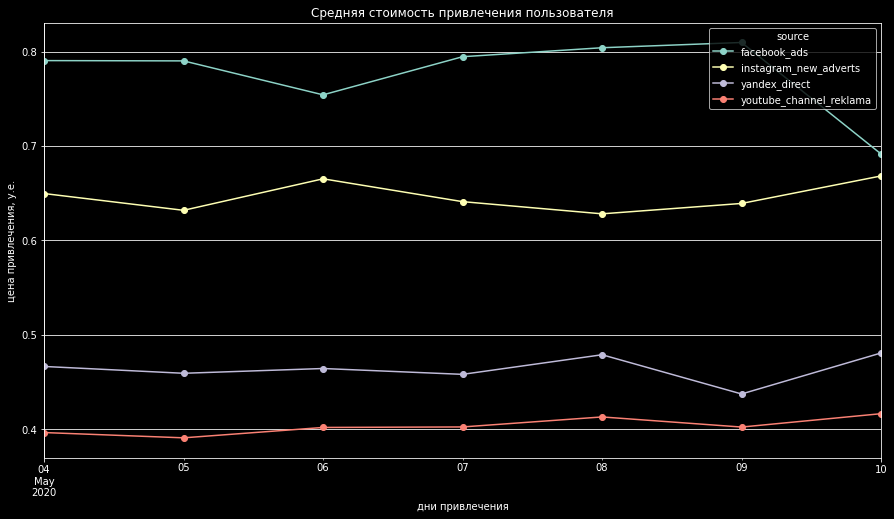

In [80]:
first_session_users_number_costs.pivot_table(values='avg_user_acquisition_cost', index='first_session_date', columns='source') \
.plot(grid=True, figsize=(15, 8), title='Средняя стоимость привлечения пользователя', \
                              xlabel='дни привлечения', ylabel='цена привлечения, у.е.', \
                              linestyle='-', marker='o')
plt.show()

Можно сделать вывод о том, что стоимость привлечения, в целом, по когортам не меняется. Самые дешевые источника трафика - youtube и yandex, а самый дорогой - facebook.
Канал facebook_ads показал в последний день некоторое снижение, с 0.8 до менее 0.7.

#### Рассчитать LTV (доход от суммарного показа рекламных роликов - стоимость привлечения) в разрезе источников привлечения.

Доход от показа 1 рекламного ролика (показывается перед строительством каждого здания) - 0.07 у.е.

In [81]:
ads_view_revenue = 0.07

In [82]:
# сгруппируем таблицу united_user_data по пользователям, рассчитав, количество просмотренных рекламных роликов
ltv_user_data = united_user_data.groupby(['user_id', 'source', 'first_session_date'], as_index=False).agg(ads_viewed_count=('event', 'count'))

In [83]:
# добавим каждому user_id данные о стоимость его привлечения из таблицы first_session_users_number_costs
ltv_user_data = ltv_user_data.merge(first_session_users_number_costs[['source', 'first_session_date', 'avg_user_acquisition_cost']], how='left', on=['source', 'first_session_date'])

In [84]:
# рассчитаем ltv с учетом дохода от показа рекламного ролика
ltv_user_data['ltv'] = ltv_user_data['ads_viewed_count'] * ads_view_revenue - ltv_user_data['avg_user_acquisition_cost']

In [85]:
# сгруппируем ltv_user_data по источнику привлечения и аггрегируем по медианному значению ltv
ltv_user_data_grouped = ltv_user_data.groupby(['source', 'first_session_date'], as_index=False).agg(median_ltv=('ltv', 'median'))

In [86]:
# проверка
ltv_user_data_grouped.head()

,source,first_session_date,median_ltv
0,facebook_ads,2020-05-04,0.049558
1,facebook_ads,2020-05-05,-0.020136
2,facebook_ads,2020-05-06,-0.054162
3,facebook_ads,2020-05-07,-0.199563
4,facebook_ads,2020-05-08,-0.384078


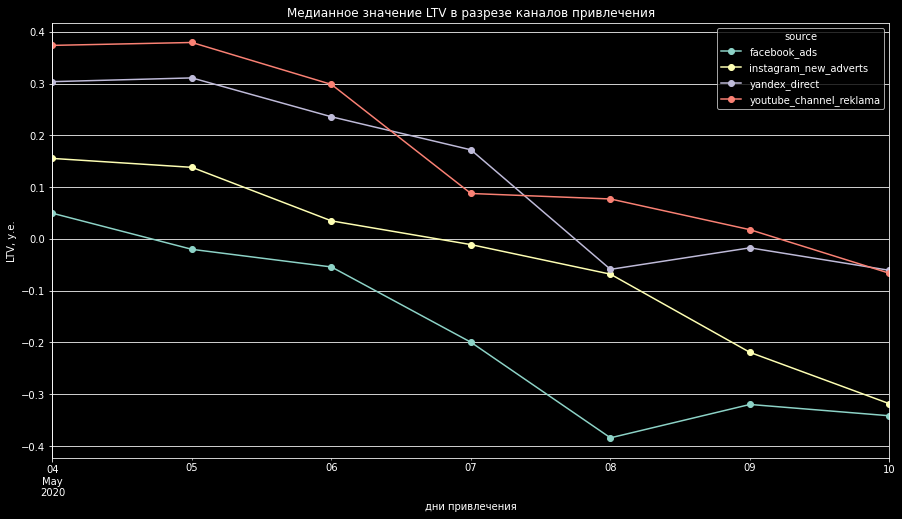

In [87]:
ltv_user_data_grouped.pivot_table(values='median_ltv', index='first_session_date', columns='source') \
.plot(grid=True, figsize=(15, 8), title='Медианное значение LTV в разрезе каналов привлечения', \
                              xlabel='дни привлечения', ylabel='LTV, у.е.', \
                              linestyle='-', marker='o')
plt.show()

Значение LTV показывает, что LTV пользователей каналов youtube и yandex выше, чем у других каналов. Однако заметна разница LTV для разных когорт: для когорты от 04.05 он для всех положительный, а для когорты от 10.05 он для всех источников привлечения отрицательный.

### Выводы

- Между когортами наблюдается снижение целеустремленности, однако это также объясняется количеством пользователей в когортах - отличие на порядок. 45-50% игроков, привлеченных 04 мая, завершают уровень 1, в то время, как процент таких игроков от 10 мая не превышает 35%.

- Анализ показывает, что пользователи-воители, в среднем, проходят уровень на 2 дня быстрее, чем пользователи-строители.

- Пользователи всех когорот (с учетом игнорирования от канала привлечения), в среднем, с одинаковой интенсивностью возводят построки.

- Стоимость привлечения, в целом, по когортам не меняется. Самые дешевые источника трафика - youtube и yandex, а самый дорогой - facebook.

- Значение LTV показывает, что LTV пользователей каналов youtube и yandex выше, чем у других каналов. Однако заметна разница LTV для разных когорт: для когорты от 04.05 он для всех положительный, а для когорты от 10.05 он для всех источников привлечения отрицательный.

## Формулировка гипотезы о равенстве времени завершения уровня в зависимости от способа прохождения. Расчет статистической значимости различий.




Сформулируем гипотезу. 
- Нулевая гипотеза (H0): среднее время завершения уровня пользователями-строителями и пользователями-воителями одинаково.
- Альтернативная гипотеза (H1): пользователи-строители и пользователи-воители тратят, в среднем, статистически разное время на прохождение уровня.

Выше мы рассматривали время прохождения уровня, но в днях. Так как среднее время прохождения уровня исчисляется днями, для исследования гипотезы целесообразно оперировать часами.

In [88]:
first_session_time = game_actions_df.sort_values(by='event_datetime_full', ascending=True) \
                                    .groupby('user_id', as_index=False) \
                                    .agg(first_session_time=('event_datetime_full', 'first'))

In [89]:
first_session_time.head()

,user_id,first_session_time
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58


In [90]:
game_actions_df_finished_stage = game_actions_df.merge(first_session_time, how='left', on='user_id')

In [91]:
game_actions_df_finished_stage = game_actions_df_finished_stage.query('event=="finished_stage_1"')

In [92]:
game_actions_df_finished_stage.head()

,event_datetime,event,building_type,user_id,project_type,event_datetime_full,first_session_time
6659,2020-05-04,finished_stage_1,None,ced7b368-818f-48f6-9461-2346de0892c5,None,2020-05-04 19:47:29,2020-05-04 00:13:21
13134,2020-05-05,finished_stage_1,None,7ef7fc89-2779-46ea-b328-9e5035b83af5,None,2020-05-05 13:22:09,2020-05-04 00:22:48
15274,2020-05-05,finished_stage_1,None,70db22b3-c2f4-43bc-94ea-51c8d2904a29,None,2020-05-05 18:54:37,2020-05-04 13:41:55
16284,2020-05-05,finished_stage_1,None,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,None,2020-05-05 21:27:29,2020-05-04 00:57:02
19650,2020-05-06,finished_stage_1,None,58e077ba-feb1-4556-a5a0-d96bd04efa39,None,2020-05-06 06:02:22,2020-05-04 19:23:40


In [93]:
game_actions_df_finished_stage['duration'] = pd.to_datetime(game_actions_df_finished_stage['event_datetime_full']) \
                                            - pd.to_datetime(game_actions_df_finished_stage['first_session_time'])

In [94]:
game_actions_df_finished_stage.head()

,event_datetime,event,building_type,user_id,project_type,event_datetime_full,first_session_time,duration
6659,2020-05-04,finished_stage_1,None,ced7b368-818f-48f6-9461-2346de0892c5,None,2020-05-04 19:47:29,2020-05-04 00:13:21,0 days 19:34:08
13134,2020-05-05,finished_stage_1,None,7ef7fc89-2779-46ea-b328-9e5035b83af5,None,2020-05-05 13:22:09,2020-05-04 00:22:48,1 days 12:59:21
15274,2020-05-05,finished_stage_1,None,70db22b3-c2f4-43bc-94ea-51c8d2904a29,None,2020-05-05 18:54:37,2020-05-04 13:41:55,1 days 05:12:42
16284,2020-05-05,finished_stage_1,None,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,None,2020-05-05 21:27:29,2020-05-04 00:57:02,1 days 20:30:27
19650,2020-05-06,finished_stage_1,None,58e077ba-feb1-4556-a5a0-d96bd04efa39,None,2020-05-06 06:02:22,2020-05-04 19:23:40,1 days 10:38:42


In [95]:
game_actions_df_finished_stage['duration_hours'] = round(game_actions_df_finished_stage['duration'].dt.components['days']*24 \
                                                    + game_actions_df_finished_stage['duration'].dt.components['hours'] \
                                                    + game_actions_df_finished_stage['duration'].dt.components['minutes'] / 60, 1)

In [96]:
# проверка
game_actions_df_finished_stage.head()

,event_datetime,event,building_type,user_id,project_type,event_datetime_full,first_session_time,duration,duration_hours
6659,2020-05-04,finished_stage_1,None,ced7b368-818f-48f6-9461-2346de0892c5,None,2020-05-04 19:47:29,2020-05-04 00:13:21,0 days 19:34:08,19.6
13134,2020-05-05,finished_stage_1,None,7ef7fc89-2779-46ea-b328-9e5035b83af5,None,2020-05-05 13:22:09,2020-05-04 00:22:48,1 days 12:59:21,37.0
15274,2020-05-05,finished_stage_1,None,70db22b3-c2f4-43bc-94ea-51c8d2904a29,None,2020-05-05 18:54:37,2020-05-04 13:41:55,1 days 05:12:42,29.2
16284,2020-05-05,finished_stage_1,None,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,None,2020-05-05 21:27:29,2020-05-04 00:57:02,1 days 20:30:27,44.5
19650,2020-05-06,finished_stage_1,None,58e077ba-feb1-4556-a5a0-d96bd04efa39,None,2020-05-06 06:02:22,2020-05-04 19:23:40,1 days 10:38:42,34.6


In [97]:
# создадим 2 группы: таблицу со временем прохождения уровня для пользователей-строителей и пользователей-воителей
group_warriors = game_actions_df_finished_stage.query('user_id in @warrior_users_set')[['user_id', 'duration_hours']]

In [98]:
group_builders = game_actions_df_finished_stage.query('user_id in @builder_users_set')[['user_id', 'duration_hours']]

In [99]:
# проверка
group_warriors.shape[0] + group_builders.shape[0] == game_actions_df_finished_stage.shape[0]

True

Рассмотрим разницу дисперсий методом .bartlett библиотеки scipy

In [100]:
stat, p = st.bartlett(group_builders['duration_hours'], group_warriors['duration_hours'])
p

2.0510922379377826e-14

Дисперсии не равны (p-value существенно меньше стандартного уровня 0.05), поэтому при использовании t-test укажем аргумент equal_var=False

In [101]:
alpha = .05

In [102]:
results = st.ttest_ind(group_builders['duration_hours'], group_warriors['duration_hours'], equal_var=False)

In [103]:
print('p-значение: ', results.pvalue)

p-значение:  5.628716503871697e-107


In [104]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Отвергаем нулевую гипотезу


Таким образом, можно отвергнуть гипотезу о равенстве среднего времени завершения уровня пользователями-строителями и пользователями-воителями. Время прохождения уровня статистически различно.

## Формулировка гипотезы о равенстве количества построенных игровых объектов (до получения возможности завершения уровня) в зависимости от способа прохождения. Расчет статистической значимости различий.

Сформулируем гипотезу. 
- Нулевая гипотеза (H0): среднее количество построенных игровых объектов (и просмотренных рекламных роликов) пользователями-строителями и пользователями-воителями одинаково.
- Альтернативная гипотеза (H1): пользователи-строители и пользователи-воители стоят, в среднем, статистически разное количество объектов до получения возможности завершения уровня.

**Необходимое напоминание**: воители автоматически завершают уровень, победив противника, а строители, при реализаии проекта, получают возможность играть далее, не завершая уровень, но имея такую возможность.

In [105]:
# получим список user_id и количество построенных ими объектов
warriors_buildings_count = game_actions_df.query('user_id in @warrior_users_set and event == "building"') \
                                            .groupby('user_id', as_index=False) \
                                            .agg(buildings_count=('event', 'count'))

In [106]:
project_finished_dates = game_actions_df.query('user_id in @builder_users_set and event == "project"')[['user_id', 'event_datetime_full']]

In [107]:
project_finished_dates.columns = ['user_id', 'project_finished_date']

In [108]:
builders_buildings_count = game_actions_df.query('user_id in @builder_users_set')

In [109]:
builders_buildings_count.head()

,event_datetime,event,building_type,user_id,project_type,event_datetime_full
1,2020-05-04,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,None,2020-05-04 00:00:03
8,2020-05-04,building,assembly_shop,65a92713-5969-48b1-8945-bfefa5063887,None,2020-05-04 00:00:44
9,2020-05-04,building,assembly_shop,fa352362-d258-472c-b295-2796ccc39fa3,None,2020-05-04 00:01:33
13,2020-05-04,building,assembly_shop,7b3b6554-7949-4065-9808-d6c79bdc2f58,None,2020-05-04 00:02:56
20,2020-05-04,building,assembly_shop,b374304d-2f74-4cc1-a4e2-500da44a06c7,None,2020-05-04 00:03:46


In [110]:
builders_buildings_count = builders_buildings_count.merge(project_finished_dates, how='left', on='user_id')

In [111]:
# отфильтруем события постройки объектов по дате создания 
builders_buildings_count = builders_buildings_count.query('event_datetime_full < project_finished_date and event == "building"')

In [112]:
# сгруппируем по пользователям и посчитаем количество построек
builders_buildings_count = builders_buildings_count.groupby('user_id', as_index=False).agg(buildings_count=('event', 'count'))[['user_id', 'buildings_count']]

Рассмотрим разницу дисперсий методом .bartlett библиотеки scipy

In [113]:
stat, p = st.bartlett(warriors_buildings_count['buildings_count'], builders_buildings_count['buildings_count'])
p

4.300102096540669e-148

Дисперсии не равны (p-value значительно меньше стандартного уровня 0.05), поэтому при использовании t-test укажем аргумент equal_var=False

In [114]:
alpha = .05

In [115]:
results = st.ttest_ind(warriors_buildings_count['buildings_count'], builders_buildings_count['buildings_count'], equal_var=False)

In [116]:
print('p-значение: ', results.pvalue)

p-значение:  9.716484997156455e-285


In [117]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Отвергаем нулевую гипотезу


Таким образом, можно сделать вывод, что пользователи-строители и пользователи-воители стоят, в среднем, статистически разное количество объектов до получения возможности завершения уровня.

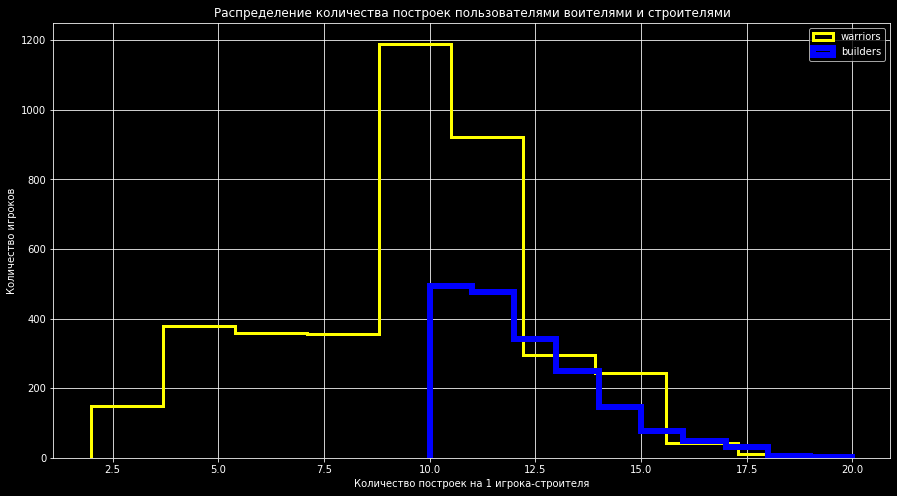

In [118]:
# графическое отражение количества построек
plt.figure(figsize=(15, 8))

plot = plt.hist(warriors_buildings_count['buildings_count'], bins=10, histtype='step', linewidth=3, color='yellow', label='warriors')
plot = plt.hist(builders_buildings_count['buildings_count'], bins=10, histtype='step', linewidth=6, color='blue', label='builders')
plt.grid()
plt.legend()

plt.title('Распределение количества построек пользователями воителями и строителями')
plt.xlabel('Количество построек на 1 игрока-строителя')
plt.ylabel('Количество игроков')
plt.show()




## Выводы. Формулирование рекомендаций

В настоящем проекте выполнен анализ логов и таблиц о рекламных каналах мобильной игры Cosmic Brothers.

Выполнена предобработка данных и исследовательский аналзы, который позволил сделать следующие выводы:

- Между когортами наблюдается снижение целеустремленности, котоое также объясняется существенным снижением закупки между когортами (количество игроков в когорте от 04 мая на порядок превышает количество от 10 мая). 45-50% игроков, привлеченных 04 мая, завершают уровень 1, в то время, как процент таких игроков от 10 мая не превышает 35%.

- Анализ показывает, что пользователи-воители, в среднем, проходят уровень на 2 дня быстрее, чем пользователи-строители, и проверка гипотезы о равенстве продолжительности прохождения, показала, что это так - различия статистически значимы.

- Пользователи всех когорот (с учетом игнорирования от канала привлечения), в среднем, с одинаковой интенсивностью возводят построки.

- Стоимость привлечения, в целом, по когортам не меняется. Самые дешевые источника трафика - youtube и yandex, а самый дорогой - facebook.

- Значение LTV показывает, что LTV пользователей каналов youtube и yandex выше, чем у других каналов. Однако заметна разница LTV для разных когорт: для когорты от 04.05 он для всех положительный, а для когорты от 10.05 он для всех источников привлечения отрицательный.


**Рекомендации**


1. Целесообразно увеличить трафик youtube и yandex, так как LTV пользователей этих каналов привлечения самые высокие (преимущественно, из-за низкой стоимости).

2. Целесообразно увеличить процент пользователей, проходящих уровень 1, так как за период наблюдений выявлено, что его проходит 42.8%. Возможно, имеет смысл пересмотреть сложность уровня.

3. Целесообразно рассмотреть возможность изменения стратегии прохождения уровня посредством победы над противником, например, добавив возможность строительства объекта защиты (стена, дот) или объекта нападения (силовые модули, источники генерации ресурсов и энергии) - это позволит:
	- показывать пользователям-воителям дополнительные рекламные ролики;
	- может сократить разницу в количестве построенных объектов между строителями и воителями;
У данного решения есть минус - возможное увеличение продолжительности прохождения уровня, что может сократить процент пользователей, которые завершат его.
